In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
# from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PERSONAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PERSONAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PERSONAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['type', 'message'])

print(df.head())

   type                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
tokens = word_tokenize(df['message'][0])
print(tokens)

['Go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'Cine', 'there', 'got', 'amore', 'wat', '...']


Let´s find the proportion of message which are ham and spam

In [5]:
df.groupby('type').count()

,message
type,
ham,4825
spam,747


Text(0.5, 0, 'Type')

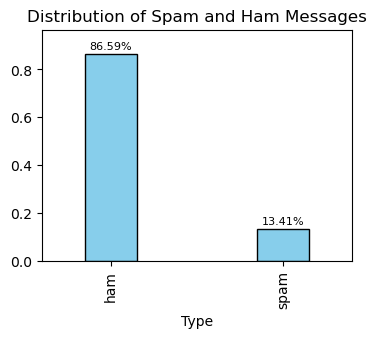

In [6]:
plt.figure(figsize=(4, 3))
proportion = df['type'].value_counts(normalize=True)
bars = proportion.plot(kind='bar', width=0.3, color='skyblue', edgecolor='black')
plt.ylim(0, proportion.max() + 0.1)

for i, value in enumerate(proportion):
    bars.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom', fontsize=8)

plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Type')

In [7]:
# There's an umbalanced in the data, the ham messages are more common than spam.
# This is somenthing to take care at the moment of creating a model to predict future predictions in messages.
# Let's look for the most common messages by type or category.

In [8]:
df_ham_counts = df[df['type']=='ham'].groupby('message').aggregate(count=('message', 'size')).reset_index()
df_ham_counts = df_ham_counts.sort_values('count', ascending=False)
df_ham_counts.head(10)

,message,count
3327,"Sorry, I'll call later",30
1524,I cant pick the phone right now. Pls send a me...,12
2892,Ok...,10
2795,Ok,4
4342,Your opinion about me? 1. Over 2. Jada 3. Kusr...,4
2920,Okie,4
62,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
2872,Ok.,4
3906,"Wen ur lovable bcums angry wid u, dnt take it ...",4
3144,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4


In [9]:
df_spam_counts = df[df['type']=='spam'].groupby('message').aggregate(count=('message', 'size')).reset_index()
df_spam_counts = df_spam_counts.sort_values('count', ascending=False)
df_spam_counts.head(10)

,message,count
337,Please call our customer service representativ...,4
264,I don't know u and u don't know me. Send CHAT ...,3
160,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,3
79,Camera - You are awarded a SiPix Digital Camer...,3
227,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...,3
284,"Loan for any purpose £500 - £75,000. Homeowner...",3
564,YES! The only place in town to meet exciting a...,2
230,HOT LIVE FANTASIES call now 08707509020 Just 2...,2
68,Buy Space Invaders 4 a chance 2 win orig Arcad...,2
592,You have 1 new voicemail. Please call 08719181...,2


In [10]:
# Now it'd be good to recognize patterns in the data like the length of the messages, with a general overview of the data 
# the spam messages seems to have a larger length.

In [11]:
df_message_length = df.copy()
df_message_length['length'] = df_message_length['message'].apply(lambda x: len(x))


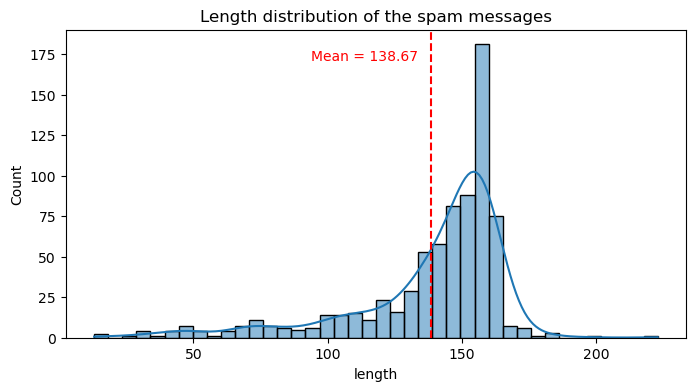

In [12]:
mean_length = df_message_length[df_message_length['type'] == 'spam']['length'].mean()
plt.figure(figsize=(8,4))
sns.histplot(df_message_length[df_message_length['type']=='spam']['length'], kde=True)
plt.axvline(mean_length, color='red', linestyle='--', label='Mean Spam Length')
plt.text(mean_length - 45, plt.ylim()[1]*0.9, f'Mean = {mean_length:.2f}', color='red')
plt.title('Length distribution of the spam messages')
plt.show()

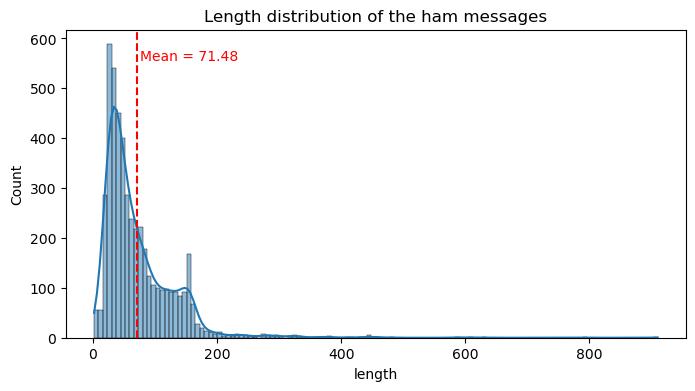

In [13]:
mean_length = df_message_length[df_message_length['type'] == 'ham']['length'].mean()
plt.figure(figsize=(8,4))
sns.histplot(df_message_length[df_message_length['type']=='ham']['length'], kde=True)
plt.axvline(mean_length, color='red', linestyle='--', label='Mean Ham Length')
plt.text(mean_length + 4, plt.ylim()[1]*0.9, f'Mean = {mean_length:.2f}', color='red')
plt.title('Length distribution of the ham messages')
plt.show()

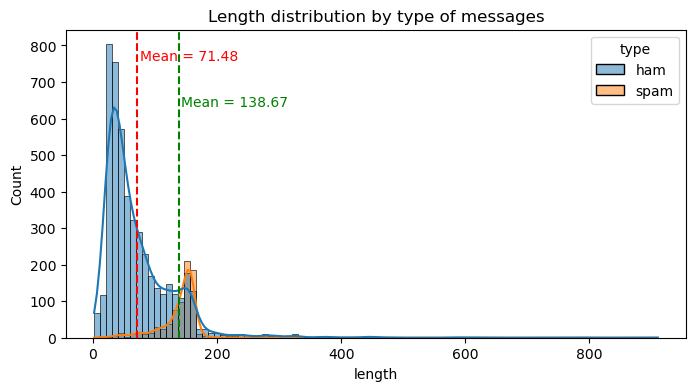

In [14]:
mean_length_ham = df_message_length[df_message_length['type'] == 'ham']['length'].mean()
mean_length_spam = df_message_length[df_message_length['type'] == 'spam']['length'].mean()
plt.figure(figsize=(8,4))
sns.histplot(data = df_message_length, x='length', kde=True, hue='type')
plt.axvline(mean_length_ham, color='red', linestyle='--', label='Mean Spam Length')
plt.axvline(mean_length_spam, color='green', linestyle='--', label='Mean Spam Length')
plt.text(mean_length_ham + 4, plt.ylim()[1]*0.9, f'Mean = {mean_length_ham:.2f}', color='red')
plt.text(mean_length_spam + 4, plt.ylim()[1]*0.75, f'Mean = {mean_length_spam:.2f}', color='green')
plt.title('Length distribution by type of messages')
plt.show()

In [15]:
# The plots suggest that the messages with more lenth tend to be spam, but this is not a rule.
# Let's see if we can find some words that are more common in spam messages than in ham messages.

In [16]:
# tokens = word_tokenize(df['message'][0])

def counter_words(df, msg_type):
    '''
    Parameters
    . df: DataFrame with columns 'type' and 'message'
    . type: str, 'spam' or 'ham'
    Returns
    . dictionaty with the words anthe frecuency of the words
    '''
    messages = df[df['type'] == msg_type]['message']
    stop_words = set(stopwords.words('english'))
    counted_words = {}
    
    for message in messages:
        tokens = word_tokenize(message.lower())
        for j in tokens:
            if j not in stop_words and j.isalpha():
                counted_words[j] = counted_words.get(j, 0) + 1
                
    return counted_words

spam_words = counter_words(df, 'spam')
ham_words = counter_words(df, 'ham')
spam_words_fr = pd.DataFrame(list(spam_words.items()), columns=['word', 'count'])
ham_words_fr = pd.DataFrame(list(ham_words.items()), columns=['word', 'count'])

In [17]:
#Let's dislay the top ten words more repetetives in each category
print('Top ten words of spam category\n')
print(spam_words_fr.sort_values(by='count', ascending=False).head(10))
print('\nTop ten words of ham category\n')
print(ham_words_fr.sort_values(by='count', ascending=False).head(10))

Top ten words of spam category

       word  count
42     call    346
0      free    219
14      txt    156
86       ur    144
48        u    142
46   mobile    123
10     text    121
248    stop    118
41    claim    113
63    reply    104

Top ten words of ham category

     word  count
20      u    994
227    gt    318
226    lt    316
232   get    302
0      go    251
118    ur    247
16     ok    246
13    got    245
155  know    237
37   like    233


In [30]:
# Let's make a prediciton of the messages to see which spam or ham

stop_words = set(stopwords.words('english'))

def message_clean(message):
    tokens = word_tokenize(message.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

df['clean_message'] = df['message'].apply(message_clean)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean_message'])
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       966
        spam       0.85      0.94      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115

